## 3. 모델링 

#### 3.1 데이터 불러오기

In [1]:
# 이미지들을 NumPy 형식으로 변환하기
import numpy as np
from PIL import Image
import os, glob, random

outfile = "image/photos.npz" # 저장할 파일 이름
max_photo = 500 # 사용할 장 수
photo_size = 64 # 이미지 크기
x = [] # 이미지 데이터
y = [] # 레이블 데이터

def main():
    # 디렉터리 읽어 들이기 
    glob_files("./image/chicolita", 0)
    glob_files("./image/manbo",1)
    glob_files("./image/poolin",2)
    glob_files("./image/popora",3)
    glob_files("./image/riako",4)
    glob_files("./image/bogi", 5)
    glob_files("./image/kc",6)


    # 파일로 저장하기 
    np.savez(outfile, x=x, y=y)
    print("저장했습니다:" + outfile, len(x))

# path 내부의 이미지 읽어 들이기 
def glob_files(path, label):
    files = glob.glob(path + "/*.jpg")
    random.shuffle(files)
    # 파일 처리하기
    num = 0
    for f in files:
        if num >= max_photo: break
        num += 1
        # 이미지 파일 읽어 들이기
        img = Image.open(f)
        img = img.convert("RGB") # 색공간 변환하기
        img = img.resize((photo_size, photo_size)) # 크기 변경하기
        img = np.asarray(img)
        x.append(img)
        y.append(label)

if __name__ == '__main__':
    main()

저장했습니다:image/photos.npz 3430


#### 3.2 불러온 이미지 확인 

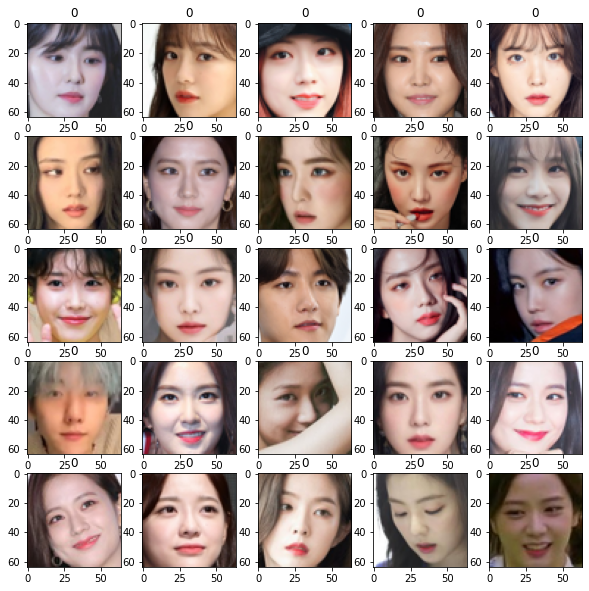

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# 사진 데이타 읽어 들이기
photos = np.load("image/photos.npz")
x = photos["x"]
y = photos["y"]

# 시작 인덱스 
idx = 0  # 100 or 200으로 변경하여 다른 이미지도 확인하기

# pyplot으로 출력하기
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.title(y[i+idx])
    plt.imshow(x[i+idx])
    
plt.show()        

#### 3.3 CNN 모델 

In [64]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import RMSprop, Adam

# CNN 모델 정의하기
def def_model(in_shape, nb_classes):
    model = Sequential()
    model.add(Conv2D(32,
              kernel_size=(3, 3),
              activation='relu',
              input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(padding='SAME'))
    model.add(Dropout(0.25))  

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(padding='SAME'))
    model.add(Dropout(0.25))  

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    return model

# 컴파일하고 모델 반환하기
def get_model(in_shape, nb_classes):
    model = def_model(in_shape, nb_classes)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.025), 
        metrics=['accuracy'])
    return model

In [65]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 7, 7, 64)         

#### 3.4 모델 train

In [66]:
import cnn_model
import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import cv2
from keras.callbacks import EarlyStopping


# 입력과 출력 지정하기 
im_rows = 64 # 이미지의 높이
im_cols = 64 # 이미지의 너비
im_color = 3 # 이미지의 색공간
in_shape = (im_rows, im_cols, im_color)
nb_classes = 7

# 사진 데이터 읽어 들이기 
photos = np.load('image/photos.npz')
x = photos['x']
y = photos['y']

# X 속성 데이터를 3차원 배열로 변환, 정규화하기 
x = x.reshape(-1, im_rows, im_cols, im_color)
x = x.astype('float32') / 255

# Y 레이블 데이터를 One-hot 형식으로 변환하기 
y = to_categorical(y.astype('int32'), nb_classes)

# 학습 전용과 테스트 전용으로 구분하기 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0)

# 학습 전용 데이터 수 늘리기 
x_new = []
y_new = []
for i, xi in enumerate(x_train):
    yi = y_train[i]
    for ang in range(-15, 15, 1):
        # 회전 시키기 
        center = (32, 32) # 회전 중심
        mtx = cv2.getRotationMatrix2D(center, ang, 1.0)
        xi2 = cv2.warpAffine(xi, mtx, (64, 64))
        x_new.append(xi2)
        y_new.append(yi)
        # 좌우 반전 
        xi3 = cv2.flip(xi2, 1)
        x_new.append(xi3)
        y_new.append(yi)

# 이미지를 늘린 데이터를 학습 데이터로 사용하기
print('수량을 늘리기 전=', len(y_train))
x_train = np.array(x_new)
y_train = np.array(y_new)
print('수량을 늘린 후=', len(y_train))

# CNN 모델 만들기 
model = cnn_model.get_model(in_shape, nb_classes)


# early_stopping = EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience=10)

# 학습 실행하기 
hist = model.fit(x_train, y_train,
          batch_size=64,
          epochs=20,
          verbose=1,
#           callbacks=[early_stopping],       
          validation_data=(x_test, y_test))

# 모델 평가하기 
score = model.evaluate(x_test, y_test, verbose=1)
print('정답률=', score[1], 'loss=', score[0])

수량을 늘리기 전= 2744
수량을 늘린 후= 164640
Epoch 1/20
2573/2573 [==============================] - 797s 310ms/step - loss: 0.9314 - accuracy: 0.6467 - val_loss: 0.7830 - val_accuracy: 0.7434
Epoch 2/20
2573/2573 [==============================] - 733s 285ms/step - loss: 0.4459 - accuracy: 0.8357 - val_loss: 0.8128 - val_accuracy: 0.7449
Epoch 3/20
2573/2573 [==============================] - 680s 264ms/step - loss: 0.3015 - accuracy: 0.8904 - val_loss: 0.8047 - val_accuracy: 0.7551
Epoch 4/20
2573/2573 [==============================] - 677s 263ms/step - loss: 0.2353 - accuracy: 0.9160 - val_loss: 0.8858 - val_accuracy: 0.7682
Epoch 5/20
2573/2573 [==============================] - 663s 258ms/step - loss: 0.2043 - accuracy: 0.9280 - val_loss: 0.8873 - val_accuracy: 0.7697
Epoch 6/20
2573/2573 [==============================] - 672s 261ms/step - loss: 0.1808 - accuracy: 0.9361 - val_loss: 0.9237 - val_accuracy: 0.7813
Epoch 7/20
2573/2573 [==============================] - 684s 266ms/step - loss:

In [67]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

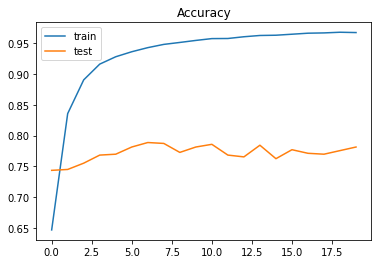

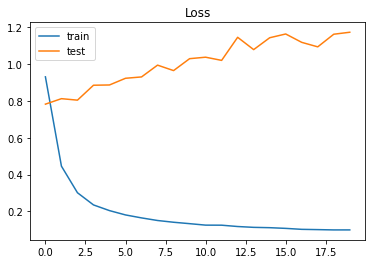

In [68]:
# 학습 상태를 그래프로 그리기 
# 정답률 추이를 그래프로 그리기
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 손실 추이를 그래프로 그리기
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [51]:
# 모델 저장
model.save('./photos-cnn-model.h5')

In [52]:
# 학습된 데이타 저장
model.save_weights('./photos-cnn-weight.hdf5')

#### 3.5 모델 test

![title](img/아이린t.jpg)

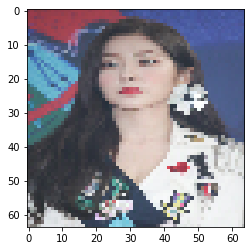

1/1 [==============================] - 0s 1ms/step
꼬부기 = 12.3340904712677
치코리타 = 81.14338517189026
케이시 = 4.3571566266109585e-05
잠만보 = 2.6529636458772754e-16
푸린 = 6.466105580329895
뽀뽀라 = 0.05628388607874513
리아코 = 8.316480943904025e-05
------------------------------------
예측한 결과 = index : 치코리타 1, 81.1434%


In [8]:
import cv2
import numpy as np
import keras
from keras.models import load_model
import matplotlib.pyplot as plt

im_rows = 64
im_cols = 64
in_shape = (im_rows, im_cols, 3)

# 레이블 정보 - 10개 클래스
labels = ["꼬부기", "치코리타", "케이시", "잠만보", "푸린", "뽀뽀라", "리아코"]

# CNN 모델 읽기
model = load_model('photos-cnn-model.h5')
# 학습된 데이타 불러오기
model.load_weights('photos-cnn-weight.hdf5')

# OpenCV를 사용해서 이미지 읽어 들이기
im = cv2.imread('img/아이린t.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
im = cv2.resize(im, (64, 64))
plt.imshow(im) # 이미지 출력하기
plt.show()

# MLP로 학습한 이미지 데이터에 형태 맞추기
im = im.reshape(in_shape).astype('float32') / 255

# 예측하기
r = model.predict(np.array([im]), batch_size=64,verbose=1)
res = r[0]

# 결과 출력하기
for i, acc in enumerate(res):
    print(labels[i], "=", float(acc * 100))
    
print("---"*12)
idx = res.argmax()
per = float(round(res[idx] * 100,4))
print("예측한 결과 = index :", labels[idx], idx , "\b,", str(per) + "%")
